In [3]:
using Plots,LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations, SimpleDiffEq
gr();  #Load in packages

In [4]:
function diff!(du,u,p,t) #System of ODEs obtained by applying method of lines with standard central difference approximation
dx,N,Drr,Dgg,krr,kgg=p

for i in 2:N-1
du[1,i]=Drr*(u[1,i-1]-2*u[1,i]+u[1,i+1])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i-1]-2*u[2,i]+u[2,i+1])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])
end
    
i=1
du[1,i]=Drr*(u[1,i+1]-u[1,i])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i+1]-u[2,i])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])
    
i=N
du[1,i]=Drr*(u[1,i-1]-u[1,i])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i-1]-u[2,i])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])        
end

diff! (generic function with 1 method)

In [5]:
function pdesolver(L,dx,N,T,ic,α1,kr,kg) #Solve the system of ODEs
krr=exp(kr); kgg = exp(kg); αα=exp(α1);
Drr = 700;    
Dgg = (αα*Drr^0.3464674798893675)^(1/0.9380422263682935);   
p=(dx,N,Drr,Dgg,krr,kgg)
tspan=(0.0,maximum(T));
prob=ODEProblem(diff!,ic,tspan,p);
alg=Heun()
sol=solve(prob,alg,saveat=T);
return sol
end

pdesolver (generic function with 1 method)

In [6]:
α1=log(700^-0.347278*380^0.937742); kr=log(0.027); kg=log(0.073); #Parameter estimates
L=1242.0; dx=5.0; #Domain and discretisation
N=Int(round(L/dx))+1;
T=[0, 16, 32, 48]; #Time at which we wish to obtain the solution
numsol=zeros(2,N,length(T));
ic=zeros(2,N);
xx=zeros(N);
data=zeros(2,24,length(T));
count=zeros(2,24,length(T));
xlocdata =[0, 54, 108, 162, 216, 270, 324, 378, 432, 486, 540, 594, 648, 702, 756, 810, 864, 918, 972, 1026, 1080, 1134, 1188, 1242];
count[1,:,1] = [23, 19, 15, 27, 19, 18, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 19, 23, 30, 26, 22, 20]; 
count[2,:,1] = [24, 14, 21, 13, 13, 18, 19, 6, 1, 0, 0, 0, 0, 0, 0, 0, 2, 14, 22, 14, 12, 13, 13, 15];
count[1,:,2] = [35, 37, 43, 25, 41, 31, 20, 21, 14, 10, 3, 1, 1, 2, 1, 10, 26, 32, 26, 27, 37, 34, 38, 38];
count[2,:,2] = [22, 14, 15, 12, 16, 11, 12, 12, 11, 6, 1, 0, 0, 1, 1, 4, 6, 12, 18, 19, 13, 12, 15, 10];
count[1,:,3] = [50, 42, 33, 40, 37, 23, 21, 19, 21, 19, 8, 6, 3, 6, 8, 15, 29, 29, 35, 38, 42, 44, 42, 53];
count[2,:,3] = [20, 14, 22, 13, 22, 16, 11, 15, 13, 11, 3, 2, 2, 2, 4, 10, 13, 9, 12, 13, 12, 14, 16, 17];
count[1,:,4] = [55, 53, 51, 52, 33, 39, 42, 41, 37, 41, 23, 24, 19, 18, 23, 28, 36, 32, 42, 45, 48, 48, 52, 50];
count[2,:,4] = [20, 15, 15, 14, 16, 17, 11, 10, 13, 7, 11, 7, 8, 4, 6, 13, 16, 14, 11, 12, 17, 18, 17, 25]
count=round.(Int,count) #Count data
maxcount=377; #Maximum number of cells per column
data=count/maxcount


interpr = linear_interpolation(xlocdata,data[1,:,1]);
interpg = linear_interpolation(xlocdata,data[2,:,1]);#Interpolate initial density

for i in 1:N
xx[i]= (i-1)*dx
ic[1,i] = interpr(xx[i])
ic[2,i] = interpg(xx[i])    
end

In [7]:
α1
700^-0.347278*380^0.937742

26.985562324814165

In [8]:
function loglhood(count,ic,a)  #loglikelihood function using multinomial noise model
numsol=pdesolver(L,dx,N,T,ic,a[1],a[2],a[3])
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());
ℓ=0.0
for ii in 1:size(count)[2]
ℓ+=(
  +log(r2(xlocdata[ii])^count[1,ii,2]*g2(xlocdata[ii])^count[2,ii,2]*(1.0-r2(xlocdata[ii])-g2(xlocdata[ii]))^(377.0-count[1,ii,2]-count[2,ii,2]))
  +log(r3(xlocdata[ii])^count[1,ii,3]*g3(xlocdata[ii])^count[2,ii,3]*(1.0-r3(xlocdata[ii])-g3(xlocdata[ii]))^(377.0-count[1,ii,3]-count[2,ii,3]))
  +log(r4(xlocdata[ii])^count[1,ii,4]*g4(xlocdata[ii])^count[2,ii,3]*(1.0-r4(xlocdata[ii])-g4(xlocdata[ii]))^(377.0-count[1,ii,4]-count[2,ii,4]))
   )
end
return ℓ
end;

In [9]:
function funmle(a) #Evaluate the loglikelihood function
return loglhood(count,ic,a)
end;

In [10]:
function Optimise(fun,θ₀,lb,ub) #Optimisation routine using Nelder Mead
tomax=(θ,∂θ)->fun(θ)
opt=Opt(:LN_NELDERMEAD,length(θ₀))
opt.max_objective=tomax
opt.lower_bounds=lb      
opt.upper_bounds=ub
optmaxtime=1*60
res = optimize(opt,θ₀)
return res[[2,1]]
end;

In [12]:
@time numsolmle=pdesolver(L,dx,N,T,ic,α1,kr,kg); 

  0.008482 seconds (173 allocations: 69.312 KiB)


In [13]:
θG=[α1,kr,kg] #Parameter estimate
lb=[log(1e-3),log(1e-3),log(1e-3)] #Bounds
ub=[log(1e2),log(0.2),log(0.2)]    #Bounds
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub) #Numerical optimization
exp.(xopt)

  2.589505 seconds (1.83 M allocations: 107.021 MiB, 1.69% gc time, 26.77% compilation time)


3-element Vector{Float64}:
 26.774966091584083
  0.028227860369452504
  0.07084444408125345

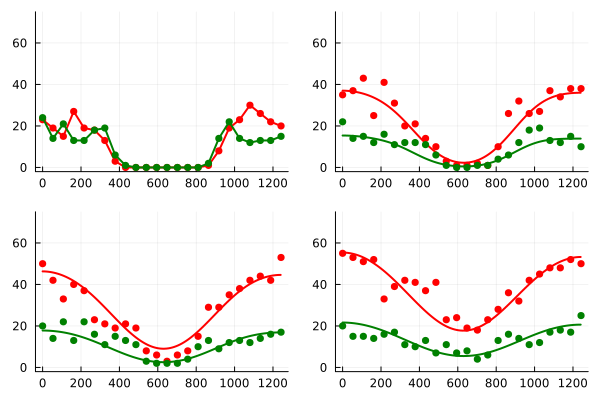

In [14]:
α1mle=xopt[1]; krmle=xopt[2]; kgmle=xopt[3]; fmle=fopt #Evaluate MLE solution and plot it on the data as a visual check
numsolmle=pdesolver(L,dx,N,T,ic,xopt[1],xopt[2],xopt[3]); 
p1=scatter(xlocdata,count[1,:,1],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p1=plot!(xx,maxcount*numsolmle[1,:,1],lw=2,color=:red)
p1=scatter!(xlocdata,count[2,:,1],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p1=plot!(xx,maxcount*numsolmle[2,:,1],lw=2,color=:green)

p2=scatter(xlocdata,count[1,:,2],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p2=plot!(xx,maxcount*numsolmle[1,:,2],lw=2,color=:red)
p2=scatter!(xlocdata,count[2,:,2],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p2=plot!(xx,maxcount*numsolmle[2,:,2],lw=2,color=:green)

p3=scatter(xlocdata,count[1,:,3],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p3=plot!(xx,maxcount*numsolmle[1,:,3],lw=2,color=:red)
p3=scatter!(xlocdata,count[2,:,3],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p3=plot!(xx,maxcount*numsolmle[2,:,3],lw=2,color=:green)

p4=scatter(xlocdata,count[1,:,4],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p4=plot!(xx,maxcount*numsolmle[1,:,4],lw=2,color=:red)
p4=scatter!(xlocdata,count[2,:,4],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p4=plot!(xx,maxcount*numsolmle[2,:,4],lw=2,color=:green)

p5=plot(p1,p2,p3,p4,layout=(2,2))
display(p5)

In [15]:
exp.(xopt)

3-element Vector{Float64}:
 26.774966091584083
  0.028227860369452504
  0.07084444408125345

In [16]:
ff(θ1,θ2,θ3) = funmle([θ1,θ2,θ3]) #Evaluate the Observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2],z[3]),xopt)

3×3 Matrix{Float64}:
  25.8067    -10.3981     4.63512
 -10.3981    663.494   -105.933
   4.63512  -105.933    758.25

In [17]:
rank(H) #Compute the rank of the observed Fisher Information at the MLE

3

In [18]:
(evals,evecs)=eigen(H) #Compute the eigenvectors/eigenvalues of the observed Fisher Information at the MLE

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
  25.625323688595472
 594.8943609947762
 827.0311512546756
vectors:
3×3 Matrix{Float64}:
 -0.99987     -0.0108938  -0.0119151
 -0.0156239    0.838835    0.544162
  0.00406679   0.544277   -0.838895

In [19]:
Q=30
α1min=log(10);  α1max=log(50);     αα1=LinRange(α1min,α1max,Q);
krmin=log(0.02); krmax=log(0.04);  kkr=LinRange(krmin,krmax,Q);
kgmin=log(0.06); kgmax=log(0.08);  kkg=LinRange(kgmin,kgmax,Q);

In [20]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

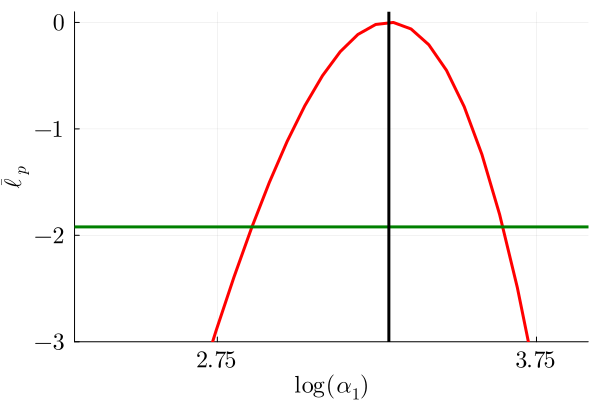

In [21]:
#Function to define univariate profile for α1
function Uα1(α1)
a=zeros(2)    
function funα1(a)
return loglhood(count,ic,[α1,a[1],a[2]])
end
θG=[krmle,kgmle]
lb=[krmin,kgmin]
ub=[krmax,kgmax]
(xopt,fopt)=Optimise(funα1,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
#println(i)
lp[i] = Uα1(αα1[i])[1]
end
q1=plot(αα1,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([α1mle],lc=:black,legend=false,xlabel=L"\log(α_1)",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(αα1),maximum(αα1)),xticks=([2.75, 3.75],[L"2.75",L"3.75"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

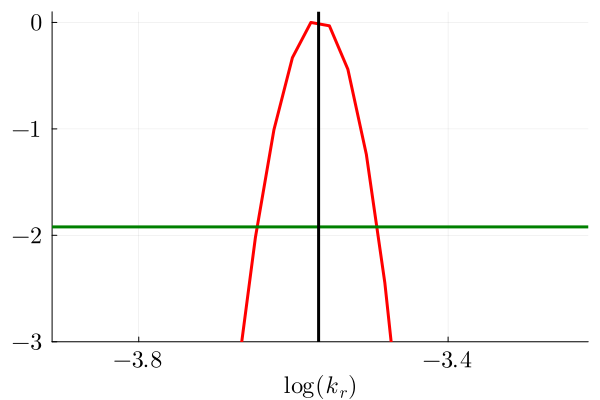

In [22]:
#Function to define univariate profile for kr 
function krr(kr)
a=zeros(2)    
function funkr(a)
return loglhood(count,ic,[a[1],kr,a[2]])
end
θG=[α1mle,kgmle]
lb=[α1min,kgmin]
ub=[α1max,kgmax]
(xopt,fopt)=Optimise(funkr,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
#println(i)
lp[i] = krr(kkr[i])[1]
end
q3=plot(kkr,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q3=hline!([llstar],legend=false,lw=3,lc=:green)
q3=vline!([krmle],lc=:black,legend=false,xlabel=L"\log(k_r)",lw=3)
q3=plot!(xlims=(minimum(kkr),maximum(kkr)),xticks=([-3.8,-3.4],[L"-3.8", L"-3.4"]))
q3=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q3=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

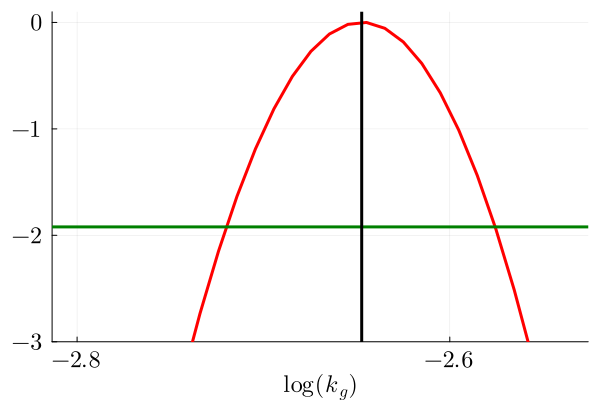

In [23]:
#Function to define univariate profile for kg 
function kgg(kg)
a=zeros(2)    
function funkg(a)
return loglhood(count,ic,[a[1],a[2],kg])
end
θG=[α1mle,krmle]
lb=[α1min,krmin]
ub=[α1max,krmax]
(xopt,fopt)=Optimise(funkg,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
#println(i)
lp[i] = kgg(kkg[i])[1]
end

q4=plot(kkg,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q4=hline!([llstar],legend=false,lw=3,lc=:green)
q4=vline!([kgmle],lc=:black,legend=false,xlabel=L"\log(k_g)",lw=3)
q4=plot!(xlims=(minimum(kkg),maximum(kkg)),xticks=([-2.6,-2.8],[L"-2.6", L"-2.8"]))
q4=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q4=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

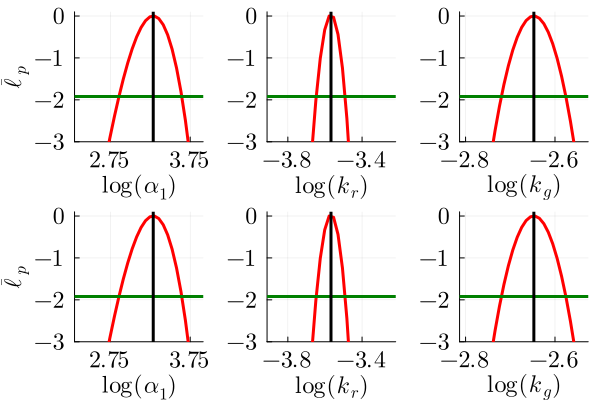

In [24]:
q5=plot(q1,q3,q4,q1,q3,q4,layout=(2,3))
savefig(q5,"Figure11.pdf")
display(q5)

In [25]:
QQ=20
α1min=log(10);  α1max=log(50);     αα1=LinRange(α1min,α1max,QQ);
krmin=log(0.02); krmax=log(0.04);  kkr=LinRange(krmin,krmax,QQ);
kgmin=log(0.05); kgmax=log(0.09);  kkg=LinRange(kgmin,kgmax,QQ);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


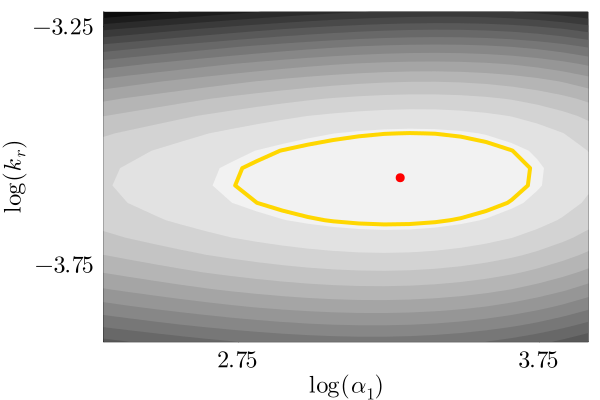

In [26]:
## Function to define bivariate profile for α1 and kr 
df=2
llstar=-quantile(Chisq(df),0.95)/2

function α1kr(α1,kr)
a=zeros(1)    
function funα1kr(a)
return loglhood(count,ic,[α1,kr,a[1]])
end
θG=[kgmle]
lb=[kgmin]
ub=[kgmax]
(xopt,fopt)=Optimise(funα1kr,θG,lb,ub)
llb=fopt
return llb,xopt
end 

lp1=zeros(QQ,QQ)
for i in 1:QQ
   println(i)
    for j in 1:QQ
    lp1[i,j] = α1kr(αα1[i],kkr[j])[1]-fmle
    end
end

b1=contourf(αα1,kkr,lp1',lw=0,xlabel=L"\log(α_1)",ylabel=L"\log(k_r)",c=:grays,colorbar=:false)
b1=scatter!([α1mle],[krmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b1=contour!(αα1,kkr,lp1',levels=[llstar],lw=4,c=:gold,legend=false)
b1=plot!(xlims=(α1min,α1max),xticks=([2.75, 3.75],[L"2.75",L"3.75"]))
b1=plot!(ylims=(krmin,krmax),yticks=([-3.25, -3.75],[L"-3.25", L"-3.75"]))
b1=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


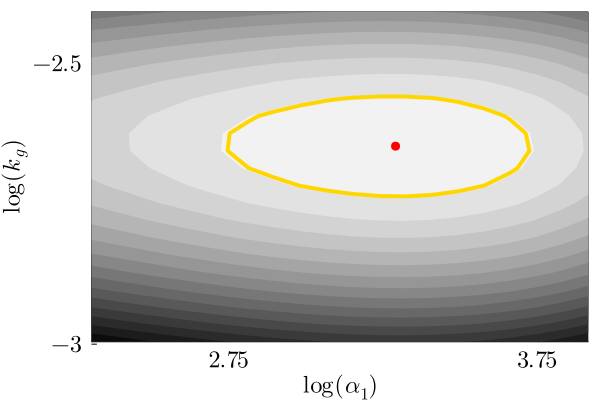

In [27]:
## Function to define bivariate profile for α1 and kg 
function α1kg(α1,kg)
a=zeros(1)    
function funα1kg(a)
return loglhood(count,ic,[α1,a[1],kg])
end
θG=[krmle]
lb=[krmin]
ub=[krmax]
(xopt,fopt)=Optimise(funα1kg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp2=zeros(QQ,QQ)
for i in 1:QQ
    println(i)
    for j in 1:QQ
    lp2[i,j] = α1kg(αα1[i],kkg[j])[1]-fmle
    end
end

b2=contourf(αα1,kkg,lp2',lw=0,xlabel=L"\log(α_1)",ylabel=L"\log(k_g)",c=:grays,colorbar=:false)
b2=scatter!([α1mle],[kgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b2=contour!(αα1,kkg,lp2',levels=[llstar],lw=4,c=:gold,legend=false)
b2=plot!(xlims=(α1min,α1max),xticks=([2.75, 3.75],[L"2.75",L"3.75"]))
b2=plot!(ylims=(kgmin,kgmax),yticks=([-3, -2.5],[L"-3", L"-2.5"]))
b2=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


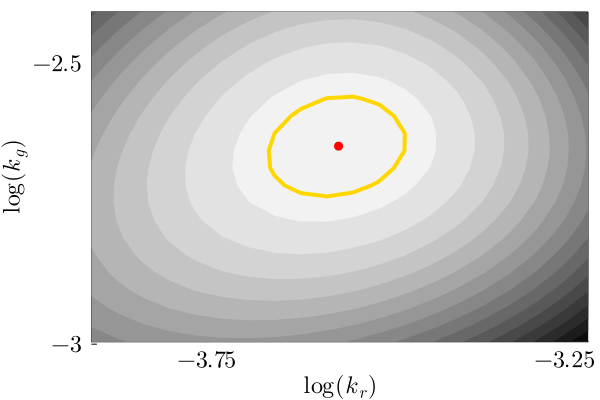

In [28]:
## Function to define bivariate profile for kr and kg 
function krkg(kr,kg)
a=zeros(1)    
function funkrkg(a)
return loglhood(count,ic,[a[1],kr,kg])
end
θG=[α1mle]
lb=[α1min]
ub=[α1max]
(xopt,fopt)=Optimise(funkrkg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp3=zeros(QQ,QQ)
for i in 1:QQ
   println(i)
    for j in 1:QQ
    lp3[i,j] = krkg(kkr[i],kkg[j])[1]-fmle
    end
end

b3=contourf(kkr,kkg,lp3',lw=0,xlabel=L"\log(k_r)",ylabel=L"\log(k_g)",c=:grays,colorbar=:false)
b3=scatter!([krmle],[kgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b3=contour!(kkr,kkg,lp3',levels=[llstar],lw=4,c=:gold,legend=false)
b3=plot!(xlims=(krmin,krmax),xticks=([-3.25, -3.75],[L"-3.25", L"-3.75"]))
b3=plot!(ylims=(kgmin,kgmax),yticks=([-3, -2.5],[L"-3", L"-2.5"]))
b3=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

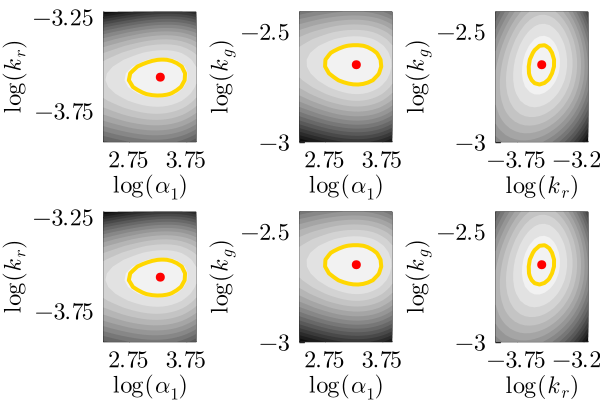

In [29]:
b4=plot(b1,b2,b3,b1,b2,b3,layout=(2,3))
savefig(b4,"Figure9.pdf")
display(b4)

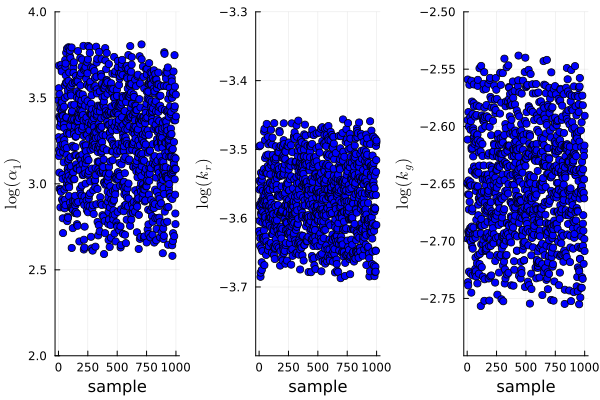

In [32]:
df=4
llstar=-quantile(Chisq(df),0.95)/2 #Sample M parameters from within the 95% confidence set fo

M=1000
α1sample=zeros(M); krsample=zeros(M); kgsample=zeros(M); lls=zeros(M)
global kount = 0
while kount < M
logα1g=rand(Uniform(2.2,4))
logkrg=rand(Uniform(-3.8,-3.3))
logkgg=rand(Uniform(-2.8,-2.5))
    
    if (loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle) >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle
    α1sample[kount]=logα1g;
    krsample[kount]=logkrg;
    kgsample[kount]=logkgg;
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_1)",ylims=(2,4))
a2=scatter(krsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_r)",ylims=(-3.8,-3.3))
a3=scatter(kgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_g)",ylims=(-2.8,-2.5))
a4=plot(a1,a2,a3,layout=(1,3))
display(a4)

In [33]:
xx = 0:1:L #For each parameter sample solve the model on a fine mesh
l_red_2=100*ones(length(xx)); l_red_3=100*ones(length(xx)); l_red_4=100*ones(length(xx));
l_green_2=100*ones(length(xx)); l_green_3=100*ones(length(xx)); l_green_4=100*ones(length(xx));
u_red_2=zeros(length(xx)); u_red_3=zeros(length(xx)); u_red_4=zeros(length(xx))
u_green_2=zeros(length(xx)); u_green_3=zeros(length(xx)); u_green_4=zeros(length(xx))


for i in 1:M
numsol=pdesolver(L,dx,N,T,ic,α1sample[i],krsample[i],kgsample[i]) #For each parameter solve the PDE model
    
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());

    for j in 1:length(xx) #At each x and t, compute the lower/upper prediction interval by computing the 0.05/0.95 quantiles of the noise model

        if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount < l_red_2[j] 
            l_red_2[j] = (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount
        end
       
        if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount < l_red_3[j] 
            l_red_3[j]  = (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount < l_red_4[j] 
            l_red_4[j] = (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount < l_green_2[j] 
            l_green_2[j] = (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount
        end
       
        if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount < l_green_3[j] 
            l_green_3[j]  = (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount < l_green_4[j] 
            l_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount
        end
        
        if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount > u_red_2[j] 
            u_red_2[j]  = (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount
        end
       
        if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount > u_red_3[j] 
            u_red_3[j] = (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount > u_red_4[j] 
            u_red_4[j] = (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount > u_green_2[j] 
            u_green_2[j]  = (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount
        end
       
        if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount > u_green_3[j] 
            u_green_3[j] = (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount > u_green_4[j] 
            u_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount
        end



    end



end

numsolmle=pdesolver(L,dx,N,T,ic,α1mle,krmle,kgmle);

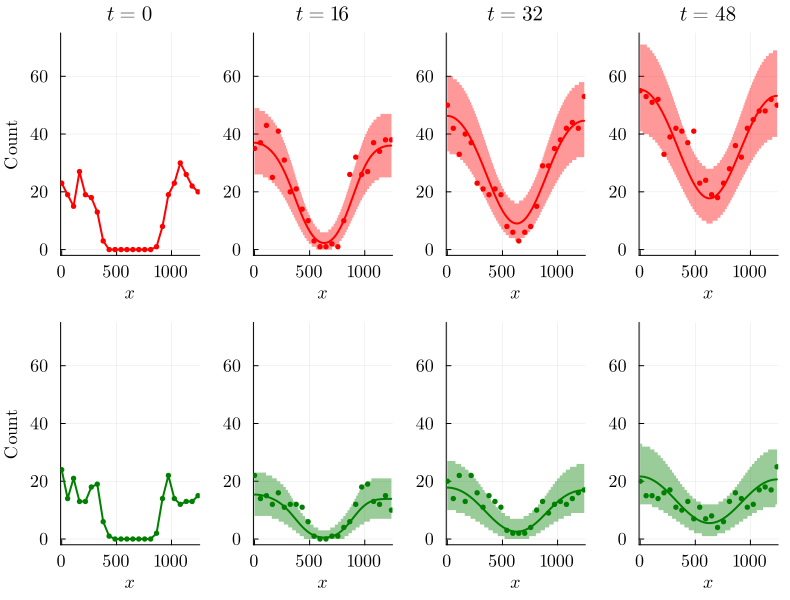

In [34]:
#Plot the prediction interval, the MLE and the data
ic1=scatter(xlocdata,count[1,:,1],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75),title=L"t=0")
ic1=plot!(0:dx:L,maxcount*numsolmle[1,:,1],lw=2,color=:red)
ic1=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

ic2=scatter(xlocdata,count[2,:,1],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75))
ic2=plot!(0:dx:L,maxcount*numsolmle[2,:,1],lw=2,color=:green)
ic2=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq1=plot(xx,maxcount*l_red_2,lw=0,fillrange=u_red_2*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq1=scatter!(xlocdata,count[1,:,2],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=16")
qq1=plot!(0:dx:L,maxcount*numsolmle[1,:,2],lw=2,color=:red)
qq1=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq2=plot(xx,maxcount*l_green_2,lw=0,fillrange=u_green_2*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq2=scatter!(xlocdata,count[2,:,2],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq2=plot!(0:dx:L,maxcount*numsolmle[2,:,2],lw=2,color=:green)
qq2=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq3=plot(xx,maxcount*l_red_3,lw=0,fillrange=u_red_3*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq3=scatter!(xlocdata,count[1,:,3],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=32")
qq3=plot!(0:dx:L,maxcount*numsolmle[1,:,3],lw=2,color=:red)
qq3=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq4=plot(xx,maxcount*l_green_3,lw=0,fillrange=u_green_3*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq4=scatter!(xlocdata,count[2,:,3],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq4=plot!(0:dx:L,maxcount*numsolmle[2,:,3],lw=2,color=:green)
qq4=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq4=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq5=plot(xx,maxcount*l_red_4,lw=0,fillrange=u_red_4*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq5=scatter!(xlocdata,count[1,:,4],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=48")
qq5=plot!(0:dx:L,maxcount*numsolmle[1,:,4],lw=2,color=:red)
qq5=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq5=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)


qq6=plot(xx,maxcount*l_green_4,lw=0,fillrange=u_green_4*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq6=scatter!(xlocdata,count[2,:,4],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq6=plot!(0:dx:L,maxcount*numsolmle[2,:,4],lw=2,color=:green)
qq6=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq6=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

rr1= plot(ic1,qq1,ic2,qq2,layout=(2,2))
rr2= plot(qq3,qq5,qq4,qq6,layout=(2,2))
rr3=plot(rr1,rr2,layout=(1,2),size=(790,600))
#savefig(rr3,"Figure8.pdf")
display(rr3)

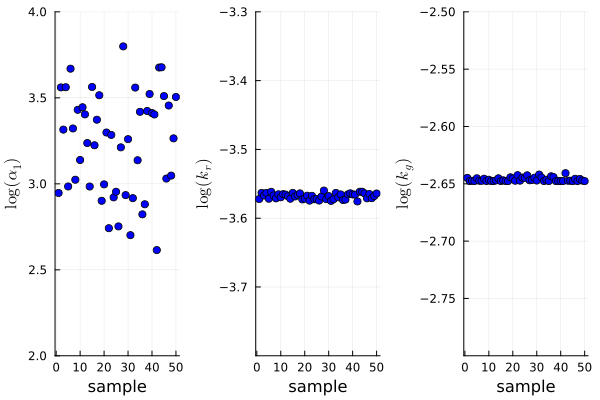

In [35]:
df=4
llstar=-quantile(Chisq(df),0.95)/2

M=50 #Generate M samples from the \alpha1 univariate profile likelihood 
α1sample=zeros(M); krsample=zeros(M); kgsample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
logα1g=rand(Uniform(2,4))
logkrg=Uα1(logα1g)[2][1]
logkgg=Uα1(logα1g)[2][2]

    
    if loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle
    α1sample[kount]=logα1g
    krsample[kount]=logkrg;
    kgsample[kount]=logkgg;
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_1)",ylims=(2,4))
a2=scatter(krsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_r)",ylims=(-3.8,-3.3))
a3=scatter(kgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_g)",ylims=(-2.8,-2.5))
a4=plot(a1,a2,a3,layout=(1,3))
display(a4)

In [36]:
xx = 0:1:L #For each sample from the \alpha1 profile likelihood solve the model on a fine mesh
U1_lower_red_2=100*ones(length(xx)); U1_lower_red_3=100*ones(length(xx)); U1_lower_red_4=100*ones(length(xx));
U1_lower_green_2=100*ones(length(xx)); U1_lower_green_3=100*ones(length(xx)); U1_lower_green_4=100*ones(length(xx));

U1_upper_red_2=zeros(length(xx)); U1_upper_red_3=zeros(length(xx)); U1_upper_red_4=zeros(length(xx));
U1_upper_green_2=zeros(length(xx)); U1_upper_green_3=zeros(length(xx)); U1_upper_green_4=zeros(length(xx))

for i in 1:M
numsol=pdesolver(L,dx,N,T,ic,α1sample[i],krsample[i],kgsample[i])
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());

    for j in 1:length(xx) #At each x and t, compute the lower/upper prediction interval by computing the 0.05/0.95 quantile of the noise model

    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount < U1_lower_red_2[j] 
    U1_lower_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount < U1_lower_red_3[j] 
    U1_lower_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount < U1_lower_red_4[j] 
    U1_lower_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount < U1_lower_green_2[j] 
    U1_lower_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount < U1_lower_green_3[j] 
    U1_lower_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount < U1_lower_green_4[j] 
    U1_lower_green_4[j]=(quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount
    end
        
    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount > U1_upper_red_2[j] 
    U1_upper_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount > U1_upper_red_3[j] 
    U1_upper_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount > U1_upper_red_4[j] 
    U1_upper_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount > U1_upper_green_2[j] 
    U1_upper_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount > U1_upper_green_3[j] 
    U1_upper_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount > U1_upper_green_4[j] 
    U1_upper_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount
    end

end



end

numsolmle=pdesolver(L,dx,N,T,ic,α1mle,krmle,kgmle);

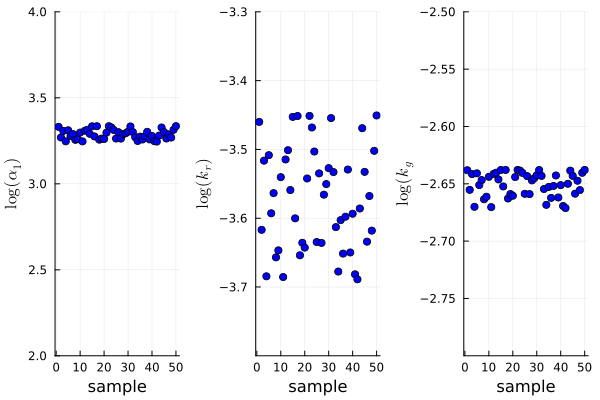

In [37]:
df=4
llstar=-quantile(Chisq(df),0.95)/2

M=50 #Generate M samples from the kr univariate profile likelihood 
α1sample=zeros(M); krsample=zeros(M); kgsample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
logkrg=rand(Uniform(-3.8,-3.3))
logα1g=krr(logkrg)[2][1]
logkgg=krr(logkrg)[2][2]



    
    if loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle
    α1sample[kount]=logα1g;
    krsample[kount]=logkrg;
    kgsample[kount]=logkgg;
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_1)",ylims=(2,4))
a2=scatter(krsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_r)",ylims=(-3.8,-3.3))
a3=scatter(kgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_g",ylims=(-2.8,-2.5))
a4=plot(a1,a2,a3,layout=(1,3))
display(a4)

In [38]:
xx = 0:1:L #For each sample from the kr profile likelihood solve the model on a fine mesh
U2_lower_red_2=100*ones(length(xx)); U2_lower_red_3=100*ones(length(xx)); U2_lower_red_4=100*ones(length(xx));
U2_lower_green_2=100*ones(length(xx)); U2_lower_green_3=100*ones(length(xx)); U2_lower_green_4=100*ones(length(xx));

U2_upper_red_2=zeros(length(xx)); U2_upper_red_3=zeros(length(xx)); U2_upper_red_4=zeros(length(xx));
U2_upper_green_2=zeros(length(xx)); U2_upper_green_3=zeros(length(xx)); U2_upper_green_4=zeros(length(xx));

for i in 1:M
numsol=pdesolver(L,dx,N,T,ic,α1sample[i],krsample[i],kgsample[i])
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());

    for j in 1:length(xx) #At each x and t, compute the lower/upper prediction interval by computing the 0.05/0.95 quantile of the noise model

    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount < U2_lower_red_2[j] 
    U2_lower_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount < U2_lower_red_3[j] 
    U2_lower_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount < U2_lower_red_4[j] 
    U2_lower_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount < U2_lower_green_2[j] 
    U2_lower_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount < U2_lower_green_3[j] 
    U2_lower_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount < U2_lower_green_4[j] 
    U2_lower_green_4[j]=(quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount
    end
        
    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount > U2_upper_red_2[j] 
    U2_upper_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount > U2_upper_red_3[j] 
    U2_upper_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount > U2_upper_red_4[j] 
    U2_upper_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount > U2_upper_green_2[j] 
    U2_upper_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount > U2_upper_green_3[j] 
    U2_upper_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount > U2_upper_green_4[j] 
    U2_upper_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount
    end

end



end

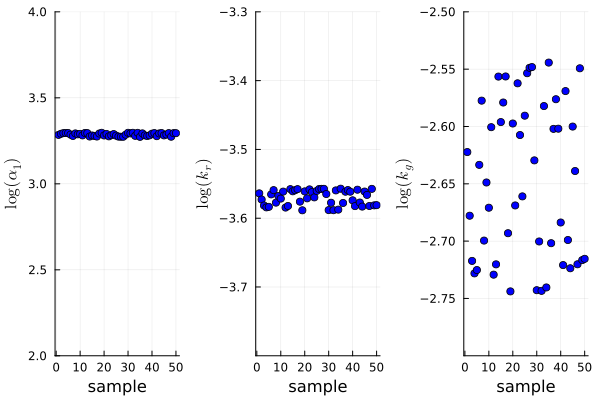

In [39]:
df=4
llstar=-quantile(Chisq(df),0.95)/2

M=50 #Generate M samples from the kg univariate profile likelihood
α1sample=zeros(M); krsample=zeros(M); kgsample=zeros(M); lls=zeros(M)
global kount = 0
while kount < M
logkgg=rand(Uniform(-2.9,-2.5))
logα1g=kgg(logkgg)[2][1]
logkrg=kgg(logkgg)[2][2]

    
    if loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(count,ic,[logα1g,logkrg,logkgg])-fmle
    α1sample[kount]=logα1g;
    krsample[kount]=logkrg;
    kgsample[kount]=logkgg;
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_1)",ylims=(2,4))
a2=scatter(krsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_r)",ylims=(-3.8,-3.3))
a3=scatter(kgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (k_g)",ylims=(-2.8,-2.5))
a4=plot(a1,a2,a3,layout=(1,3))
display(a4)

In [40]:
xx = 0:1:L #For each sample from the kg profile likelihood solve the model on a fine mesh
U3_lower_red_2=100*ones(length(xx)); U3_lower_red_3=100*ones(length(xx)); U3_lower_red_4=100*ones(length(xx));
U3_lower_green_2=100*ones(length(xx)); U3_lower_green_3=100*ones(length(xx)); U3_lower_green_4=100*ones(length(xx));

U3_upper_red_2=zeros(length(xx)); U3_upper_red_3=zeros(length(xx)); U3_upper_red_4=zeros(length(xx));
U3_upper_green_2=zeros(length(xx)); U3_upper_green_3=zeros(length(xx)); U3_upper_green_4=zeros(length(xx))

for i in 1:M
numsol=pdesolver(L,dx,N,T,ic,α1sample[i],krsample[i],kgsample[i])
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());

    for j in 1:length(xx) #At each x and t, compute the lower/upper prediction interval by computing the 0.05/0.95 quantile of the noise model
 
    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount < U3_lower_red_2[j] 
    U3_lower_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount < U3_lower_red_3[j] 
    U3_lower_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount < U3_lower_red_4[j] 
    U3_lower_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount < U3_lower_green_2[j] 
    U3_lower_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount < U3_lower_green_3[j] 
    U3_lower_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount < U3_lower_green_4[j] 
    U3_lower_green_4[j]=(quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount
    end
        
    if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount > U3_upper_red_2[j] 
    U3_upper_red_2[j]=(quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount > U3_upper_red_3[j] 
    U3_upper_red_3[j]=(quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount > U3_upper_red_4[j] 
    U3_upper_red_4[j]=(quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount > U3_upper_green_2[j] 
    U3_upper_green_2[j]=(quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount
    end
       
    if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount > U3_upper_green_3[j] 
    U3_upper_green_3[j]=(quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount
    end

    if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount > U3_upper_green_4[j] 
    U3_upper_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount
    end

end


end

In [41]:
#To approximate the full prediction interval take the union across the three profile-wise prediction intervals
U_lower_red_2=100*ones(length(xx)); U_lower_red_3=100*ones(length(xx)); U_lower_red_4=100*ones(length(xx));
U_lower_green_2=100*ones(length(xx)); U_lower_green_3=100*ones(length(xx)); U_lower_green_4=100*ones(length(xx));

U_upper_red_2=zeros(length(xx)); U_upper_red_3=zeros(length(xx)); U_upper_red_4=zeros(length(xx));
U_upper_green_2=zeros(length(xx)); U_upper_green_3=zeros(length(xx)); U_upper_green_4=zeros(length(xx));

for i in 1:length(xx)
U_lower_red_2 = min(U1_lower_red_2,U2_lower_red_2,U3_lower_red_2)
U_lower_red_3 = min(U1_lower_red_3,U2_lower_red_3,U3_lower_red_3)
U_lower_red_4 = min(U1_lower_red_4,U2_lower_red_4,U3_lower_red_4)

U_upper_red_2 = max(U1_upper_red_2,U2_upper_red_2,U3_upper_red_2)
U_upper_red_3 = max(U1_upper_red_3,U2_upper_red_3,U3_upper_red_3)
U_upper_red_4 = max(U1_upper_red_4,U2_upper_red_4,U3_upper_red_4)

U_lower_green_2 = min(U1_lower_green_2,U2_lower_green_2,U3_lower_green_2)
U_lower_green_3 = min(U1_lower_green_3,U2_lower_green_3,U3_lower_green_3)
U_lower_green_4 = min(U1_lower_green_4,U2_lower_green_4,U3_lower_green_4)

U_upper_green_2 = max(U1_upper_green_2,U2_upper_green_2,U3_upper_green_2)
U_upper_green_3 = max(U1_upper_green_3,U2_upper_green_3,U3_upper_green_3)
U_upper_green_4 = max(U1_upper_green_4,U2_upper_green_4,U3_upper_green_4)
end

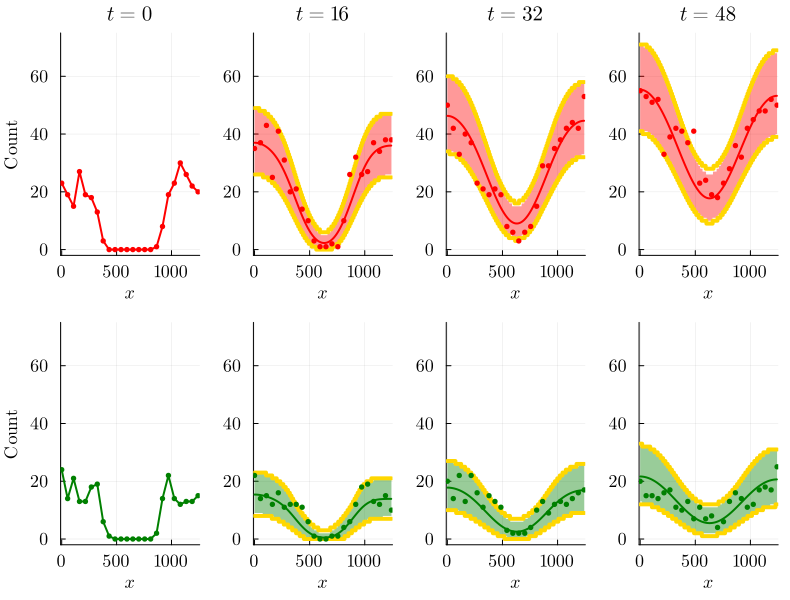

In [42]:
#Plot the full prediction interval, the union of the three profile-wise intervals, the MLE and the data
ic1=scatter(xlocdata,count[1,:,1],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75),title=L"t=0")
ic1=plot!(0:dx:L,maxcount*numsolmle[1,:,1],lw=2,color=:red)
ic1=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

ic2=scatter(xlocdata,count[2,:,1],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75))
ic2=plot!(0:dx:L,maxcount*numsolmle[2,:,1],lw=2,color=:green)
ic2=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

w1=plot(xx,maxcount*U_lower_red_2,lw=0,fillrange=U_upper_red_2*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
w1=plot!(xx,maxcount*l_red_2,lw=4,ls=:solid,lc=:gold,label=false)
w1=plot!(xx,maxcount*u_red_2,lw=4,ls=:solid,lc=:gold,label=false)    
w1=scatter!(xlocdata,count[1,:,2],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=16")
w1=plot!(0:dx:L,maxcount*numsolmle[1,:,2],lw=2,color=:red)
w1=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

w2=plot(xx,maxcount*U_lower_green_2,lw=0,fillrange=U_upper_green_2*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
w2=plot!(xx,maxcount*l_green_2,lw=4,ls=:solid,lc=:gold,label=false)
w2=plot!(xx,maxcount*u_green_2,lw=4,ls=:solid,lc=:gold,label=false) 
w2=scatter!(xlocdata,count[2,:,2],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
w2=plot!(0:dx:L,maxcount*numsolmle[2,:,2],lw=2,color=:green)
w2=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

w3=plot(xx,maxcount*U_lower_red_3,lw=0,fillrange=U_upper_red_3*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
w3=plot!(xx,maxcount*l_red_3,lw=4,ls=:solid,lc=:gold,label=false)
w3=plot!(xx,maxcount*u_red_3,lw=4,ls=:solid,lc=:gold,label=false)  
w3=scatter!(xlocdata,count[1,:,3],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=32")
w3=plot!(0:dx:L,maxcount*numsolmle[1,:,3],lw=2,color=:red)
w3=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)


w4=plot(xx,maxcount*U_lower_green_3,lw=0,fillrange=U_upper_green_3*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
w4=plot!(xx,maxcount*l_green_3,lw=4,ls=:solid,lc=:gold,label=false)
w4=plot!(xx,maxcount*u_green_3,lw=4,ls=:solid,lc=:gold,label=false) 
w4=scatter!(xlocdata,count[2,:,3],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
w4=plot!(0:dx:L,maxcount*numsolmle[2,:,3],lw=2,color=:green)
w4=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w4=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

w5=plot(xx,maxcount*U_lower_red_4,lw=0,fillrange=U_upper_red_4*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
w5=plot!(xx,maxcount*l_red_4,lw=4,ls=:solid,lc=:gold,label=false)
w5=plot!(xx,maxcount*u_red_4,lw=4,ls=:solid,lc=:gold,label=false) 
w5=scatter!(xlocdata,count[1,:,4],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=48")
w5=plot!(0:dx:L,maxcount*numsolmle[1,:,4],lw=2,color=:red)
w5=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w5=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

w6=plot(xx,maxcount*U_lower_green_4,lw=0,fillrange=U_upper_green_4*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
w6=plot!(xx,maxcount*l_green_4,lw=4,ls=:solid,lc=:gold,label=false)
w6=plot!(xx,maxcount*u_green_4,lw=4,ls=:solid,lc=:gold,label=false) 
w6=scatter!(xlocdata,count[2,:,4],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
w6=plot!(0:dx:L,maxcount*numsolmle[2,:,4],lw=2,color=:green)
w6=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
w6=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)


rr1= plot(ic1,w1,ic2,w2,layout=(2,2))
rr2= plot(w3,w5,w4,w6,layout=(2,2))
rr3=plot(rr1,rr2,layout=(1,2),size=(790,600))
savefig(rr3,"Figure8.pdf")
display(rr3)